# Just a nice stacking ensemble model...

In [1]:
import os,sys,time,random,math,time
import tarfile, zipfile

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from subprocess import check_output

from sklearn.linear_model import LinearRegression,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.svm import SVR
from sklearn import decomposition, datasets, ensemble
from sklearn.cluster import KMeans,MeanShift

from sklearn.base import clone as skclone
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import make_scorer,precision_score, recall_score, f1_score, average_precision_score, accuracy_score, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler
import itertools

import xgboost as xgb

#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Activation
#from keras.layers.advanced_activations import PReLU

import matplotlib.pyplot as plt
from IPython.display import display, Image
%matplotlib inline  

In [2]:
use_xgb=True #disable for speed

datadir="./input/"
cachedir="./cache/"
print(check_output(["ls", datadir]).decode("utf8"))
#print(check_output(["ls", cachedir]).decode("utf8"))



# XGB!

#my first tries:
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'objective': 'reg:linear',
    'max_depth': 6,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'mae',
}
#params from:
#https://www.kaggle.com/mnabaee/allstate-claims-severity/labelencoding-and-xgb-cv/discussion
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.3085,
    'silent': 1,
    'subsample': 0.5,
    'learning_rate': 0.01,
    'objective': 'reg:linear',
    'max_depth': 10,
    'num_parallel_tree': 1,
    'min_child_weight': 4.2922,
    'eval_metric': 'mae',
    'eta':0.001,
    'gamma': 0.5290,
    'subsample':0.9930,
    'max_delta_step':0,
    'booster':'gbtree',
    'nrounds': 1001
}


test.csv
test.csv.zip
test_data_all_features.csv
test_data_cats.csv
test_data_conts.csv
test_data_new.csv
test_data_orig_only.csv
test_data_validation_train_all_features.csv
test_data_validation_train_cats.csv
test_data_validation_train_conts.csv
test_data_validation_train_new.csv
test_data_validation_train_orig_only.csv
train.csv
train.csv.zip
train_data_all_features.csv
train_data_cats.csv
train_data_conts.csv
train_data_new.csv
train_data_orig_only.csv
train_data_validation_train_all_features.csv
train_data_validation_train_cats.csv
train_data_validation_train_conts.csv
train_data_validation_train_new.csv
train_data_validation_train_orig_only.csv



In [3]:
def loadData(datadir,filename):
    # Load the wholesale customers dataset
    #data = pd.read_csv(filename)
    data = ''
    print ("loading: "+datadir+filename)
    try:
        if zipfile.is_zipfile(datadir+filename):
            z = zipfile.ZipFile(datadir+filename)
            filename = z.open(filename[:-4])
        else:
            filename=datadir+filename
        data = pd.read_csv(filename, parse_dates=True)  
        print ("Dataset has {} samples with {} features each.".format(*data.shape))
    except Exception as e:
        print ("Dataset could not be loaded. Is the dataset missing?")
        print(e)
    return data

def writeData(data,filename):
    # Load the wholesale customers dataset
    try:
        data.to_csv(filename, index=False)
    except Exception as e:
        print ("Dataset could not be written.")
        print(e)
    verify=[]
    try:
        with open(filename, 'r') as f:
            for line in f:
                verify.append(line)
        f.closed
        return verify[:5]
    except IOError:
        sys.std
        

In [26]:
def prepdata(data_name,verbose=False):
    ### and now, let's import the data
    data = loadData(datadir,'train_data_'+data_name+'.csv')
    if verbose==True:
        print "load train"
        display(data.info())
        display(data.head(2))

    test_data= loadData(datadir,'test_data_'+data_name+'.csv') 
    if verbose==True:
        print "load test"
        display(test_data.info())
        display(test_data.head(2))
    # we don't want the ID columns in X
    x=data.drop(['id','loss'],1).values
    # loss is our label
    #y=data['loss'].values
    y = np.log(data['loss']+shift).ravel()

    return x,y,test_data

In [5]:

def LabelEncoder(data):
    # lifted in parts from:
    #https://www.kaggle.com/mmueller/allstate-claims-severity/yet-another-xgb-starter/code
    features = data.columns
    cats = [feat for feat in features if 'cat' in feat]
    for feat in cats:
        data[feat] = pd.factorize(data[feat], sort=True)[0]
    return data

In [6]:
def kmeansPlusmeanshift(data):
    start_time = time.time()
    startingClusterSize=int(len(data)*.075)
    print "kmeans.... for {} clusters".format(startingClusterSize)
    k_means =KMeans(n_clusters=startingClusterSize,n_jobs=10)
    k_means.fit(data.sample(frac=0.35).values)
    clusters=k_means.cluster_centers_
    print("kmeans round 1 time:{}s".format(round((time.time()-start_time), 3) ))
    print clusters[:15]
    
    start_time = time.time()
    #use the cluster centers of the guessed clusters to get an estimate of actual numbers of clusters. doing this for speed increase!
    print "\nmeanshift..."
    meanshift=MeanShift(n_jobs=10)
    meanshift.fit(clusters)
    newcenters=meanshift.cluster_centers_
    print("meanshift time:{}s".format(round((time.time()-start_time), 3) ))
    print newcenters[:15], "\nnum of clusters from meanshift:",len(newcenters)
    
    start_time = time.time()
    # use the new clusters number to predict each locations cluster
    print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
    k_means =KMeans(n_clusters=len(newcenters)+1,n_jobs=10)
    final_clusters=k_means.fit_predict(data.values)
    print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))
    return final_clusters

In [7]:
def kmeansPlusmeanshift_quick(data):  # used the one above to get the # of clusters, using this for speed
    start_time = time.time()
    # use the new clusters number to predict each locations cluster
    print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
    k_means =KMeans(n_clusters=80,n_jobs=12)
    final_clusters=k_means.fit_predict(data.values)
    print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))
    return final_clusters

In [8]:
def grid_search_wrapper(x,y,regr,param,regr_name='BLANK'):
    start_time = time.time()
    print("In:{}".format(regr))
    filename= 'grid_{}.pkl'.format(regr_name)
    if os.path.isfile(cachedir+filename):
        print filename," exists, importing "
        return joblib.load(cachedir+filename) 
    else:
        print("{} not present, running a gridsearch".format(filename))
        #search the param_grid for best params based on the f1 score
        grid_search = GridSearchCV(regr,
                                   param_grid= param,
                                   n_jobs= -1,
                                   scoring=make_scorer(mean_absolute_error,greater_is_better=False)) 
        print("debug 1")
        grid_search.fit(x,y)
        print "debug2"
        #reach into the grid search and pull out the best parameters, and set those on the clf
        params={}
        for p in grid_search.best_params_:
            params[p]=grid_search.best_params_[p]
        regr.set_params(**params)
        print("run time:{}s".format(round((time.time()-start_time), 3) ))   
        joblib.dump(regr,cachedir+filename) 
    return regr

### Setup

In [40]:
shift=200

#Which dataset?
dataset='validation_train'
dataset='final'

if dataset=='validation_train':
    data_name="validation_train_"+'all_features'  # against only local data
else:
    data_name='all_features' #for final data run for submissions to kaggle

x,y,test_data=prepdata(data_name,verbose=True)
x_test_data=test_data.drop(['loss','id'],1).values# didn't have the loss column before, make it go away! don't need ID!

loading: ./input/train_data_all_features.csv
Dataset has 188318 samples with 135 features each.
load train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 135 entries, cat1 to clusters_cat
dtypes: float64(134), int64(1)
memory usage: 194.0 MB


None

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont10,cont11,cont12,cont13,cont14,loss,id,clusters,clusters_cont,clusters_cat
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.916140,0.744792,0.761787,-0.070392,0.984628,2213.18,1,0.721519,0.177215,0.392405
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.664384,0.560798,0.585682,-0.330645,0.343682,1283.60,2,0.367089,0.556962,0.113924


loading: ./input/test_data_all_features.csv
Dataset has 125546 samples with 135 features each.
load test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125546 entries, 0 to 125545
Columns: 135 entries, cat1 to clusters_cat
dtypes: float64(134), int64(1)
memory usage: 129.3 MB


None

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont10,cont11,cont12,cont13,cont14,loss,id,clusters,clusters_cont,clusters_cat
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.618125,0.596157,0.588824,-0.208032,0.679093,0.0,4,0.367089,0.556962,0.113924
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.779139,0.823734,0.815239,-0.582283,0.000000,0.0,6,0.443038,0.531646,0.835443


In [41]:
#prepare the fold divisions --should move this somewhere else...should we make an effort to keep consistent in each file?

data_size=x.shape[0]
print "size of train data:",data_size
folds=[]
num_folds=5
fold_start=0
for k in range(num_folds-1):
    fold_end=((data_size/num_folds)*(k+1))
    folds.append((fold_start,fold_end))
    fold_start=fold_end
folds.append((fold_start,data_size))
print "folds at:",folds
print "fold size:", (data_size/num_folds)
print "train size:",(data_size/num_folds)*(num_folds-1)

count=0
for i in folds:
    count+=i[1]-i[0]
print count

size of train data: 188318
folds at: [(0, 37663), (37663, 75326), (75326, 112989), (112989, 150652), (150652, 188318)]
fold size: 37663
train size: 150652
188318


### load layer 1 results

In [42]:
#load the results from JustStacking-Layer1.ipynb
if dataset=='validation_train':
    x_layer2=joblib.load(cachedir+'x_layer2_train_validation.npy') 
else:
    x_layer2=joblib.load(cachedir+'x_layer2_train_final.npy') 


In [39]:

print x_layer2

[[  5.33574026   5.33658039   5.33574658 ...,   5.33500338   5.3366342    8.        ]
 [  5.33629278   5.33612879   5.33629736 ...,   5.33420038   5.33555127
   19.        ]
 [  5.33964102   5.33664489   5.33964669 ...,   5.34008932   5.34028853
   10.        ]
 ..., 
 [  5.33456428   5.33655766   5.33456712 ...,   5.33456898   5.33448734
   28.        ]
 [  5.33569027   5.33647061   5.33568489 ...,   5.33335781   5.33446534
   28.        ]
 [  5.3357575    5.33659664   5.33575705 ...,   5.33511543   5.33614332
   40.        ]]


In [43]:
print x_layer2

[[  7.85325636   7.76702191   7.85335006 ...,   7.69497013   7.63908946
   12.        ]
 [  7.52709803   7.75523541   7.52731666 ...,   7.56129837   7.64755106
   25.        ]
 [  8.49027983   7.79551673   8.4906646  ...,   8.39824104   8.4168177   77.        ]
 ..., 
 [  7.94185001   7.85219577   7.9422252  ...,   8.21894646   8.34633793
   10.        ]
 [  8.19652046   7.83937725   8.19711302 ...,   8.11676979   8.03095351
    9.        ]
 [  8.30812488   7.83339577   8.30800576 ...,   8.02830601   7.96112755
   19.        ]]


### train layer 2

In [33]:
# grid search on layer 2

start_time0 = time.time()

paramater_grid_Lin=dict(normalize = [True,False])
layer2_Lin_regr=grid_search_wrapper(x_layer2,y,LinearRegression(),paramater_grid_Lin,regr_name='L2_Lin')   

paramater_grid_KNN=dict(n_neighbors=[2,5,7,15,30],
                    leaf_size =[3,10,15,25,30,50,100])
layer2_KNN_regr=grid_search_wrapper(x_layer2,y,KNeighborsRegressor(n_jobs = -1),paramater_grid_KNN,regr_name='L2_KNN')   
    
print("Full GridSearch run time:{}s".format(round((time.time()-start_time0), 3) ))   


In:LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
grid_L2_Lin.pkl  exists, importing 
In:KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')
grid_L2_KNN.pkl  exists, importing 
Full GridSearch run time:0.019s


In [34]:
dtrain = xgb.DMatrix(x_layer2, label=y)

start_time = time.time()
res = xgb.cv(xgb_params, dtrain, num_boost_round=2001, nfold=4, seed=42, stratified=False,
             early_stopping_rounds=50, verbose_eval=100, show_stdv=True, maximize=False)
print("CV time:{}s".format(round((time.time()-start_time), 3) ))

best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]
print('CV-Mean: {0}+{1}'.format(cv_mean, cv_std))
print("best_nrounds:",best_nrounds)

[0]	train-mae:4.7882+8.33667e-06	test-mae:4.7882+2.57621e-05
[100]	train-mae:1.75265+3.34477e-06	test-mae:1.75265+3.13169e-05
[200]	train-mae:0.641533+1.5e-06	test-mae:0.641533+3.31399e-05
[300]	train-mae:0.234824+5e-07	test-mae:0.234823+3.37972e-05
[400]	train-mae:0.085954+0	test-mae:0.0859542+3.39513e-05
[500]	train-mae:0.0314622+4.33013e-07	test-mae:0.031462+3.42491e-05
[600]	train-mae:0.0115178+4.33013e-07	test-mae:0.011518+3.42491e-05
[700]	train-mae:0.004478+1.22474e-06	test-mae:0.00447825+3.23294e-05
[800]	train-mae:0.00304775+2.48747e-06	test-mae:0.0030475+2.36485e-05
[900]	train-mae:0.00287725+2.04634e-06	test-mae:0.002877+1.93391e-05
[1000]	train-mae:0.00286625+2.04634e-06	test-mae:0.00286625+1.74839e-05
CV time:244.39s
CV-Mean: 0.002866+1.77904468747e-05
('best_nrounds:', 977)


In [35]:
display(layer2_Lin_regr)
display(layer2_KNN_regr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

KNeighborsRegressor(algorithm='auto', leaf_size=3, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
          weights='uniform')

In [38]:
x_layer3 = []
MAE_tracking=[]
fold_counter=0

for fold_start,fold_end in folds:
    
    print("Fold {} of {} : {} to {} of: {}".format(fold_counter+1,num_folds,fold_start,fold_end,data_size))
    start_time1 = time.time()
    fold_result=[]
    fold_counter+=1
    
    X_layer2_validation = x_layer2[fold_start:fold_end].copy()
    y_layer2_validation = y[fold_start:fold_end].copy()
    X_layer2_train=np.concatenate((x_layer2[:fold_start], x_layer2[fold_end:]), axis=0)
    y_layer2_train=np.concatenate((y[:fold_start], y[fold_end:]), axis=0)
    print "\nfolding! len test {}, len train {}".format(len(X_layer2_validation),len(X_layer2_train))
    

    layer2_Lin_regr.fit(X_layer2_train,y_layer2_train)
    layer2_predict_linear=layer2_Lin_regr.predict(X_layer2_validation)
    #show some stats on that last regressions run    
    #MAE=np.mean(abs(layer2_predict_linear - y_layer2_validation))
    MAE=np.mean(abs(np.exp(layer2_predict_linear) - np.exp(y_layer2_validation)))
    MAE_tracking.append(["run:{}".format('linearLayer2'),MAE])
    print("LinearRegression Mean abs error: {:.2f}".format(MAE))
    print("Score: {:.2f}".format(layer2_Lin_regr.score(X_layer2_validation, y_layer2_validation)))
    fold_result = layer2_predict_linear
    #with LinearReg: Mean abs error: 1172.67

    #KNeighborsRegressor
    layer2_KNN_regr.fit(X_layer2_train,y_layer2_train)
    layer2_predict_KNeighbors=layer2_KNN_regr.predict(X_layer2_validation)
    #show some stats on that last regressions run    
    #MAE=np.mean(abs(layer2_predict_KNeighbors - y_layer2_validation))
    MAE=np.mean(abs(np.exp(layer2_predict_KNeighbors) - np.exp(y_layer2_validation)))
    MAE_tracking.append(["run:{}".format('KNNLayer2'),MAE])
    print("KNeighborsRegressor Mean abs error: {:.2f}".format(MAE))
    print("Score: {:.2f}".format(layer2_KNN_regr.score(X_layer2_validation, y_layer2_validation)))
    fold_result = np.column_stack((fold_result,layer2_predict_KNeighbors))  

    #Mean abs error: 1291.64

    # The XGB version of layer 2
    dtrain = xgb.DMatrix(X_layer2_train, label=y_layer2_train)
    dtest = xgb.DMatrix(X_layer2_validation)
    layer2_gbdt=xgb.train(xgb_params, dtrain, best_nrounds)
    
    # now do a prediction and spit out a score(MAE) that means something
    start_time = time.time()
    layer2_gbdt_predict=layer2_gbdt.predict(dtest)
    #MAE=np.mean(abs(layer2_gbdt_predict- y_layer2_validation))
    MAE=np.mean(abs(np.exp(layer2_gbdt_predict) - np.exp(y_layer2_validation)))
    MAE_tracking.append(["run:{}".format('XGBLayer2'),MAE])
    print("XGB Mean abs error: {:.2f}".format(MAE))
    print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))    
    fold_result = np.column_stack((fold_result,layer2_gbdt_predict))  
    
    #XGB Mean abs error: 1154.25
    
    # ? average those weighted to XGB
    layer2_avg_predict=(layer2_predict_linear+layer2_predict_KNeighbors+layer2_gbdt_predict+layer2_gbdt_predict)/4

    #MAE=np.mean(abs(layer2_avg_predict- y_layer2_validation))
    MAE=np.mean(abs(np.exp(layer2_avg_predict) - np.exp(y_layer2_validation)))

    print("AVG Mean abs error: {:.2f}".format(MAE))
    fold_result = np.column_stack((fold_result,layer2_avg_predict))  

    #AVG Mean abs error: 1163.71
    
    if x_layer3 == []:
        x_layer3=fold_result
    else:
        x_layer3=np.append(x_layer3,fold_result,axis=0)

Fold 1 of 5 : 0 to 30130 of: 150654

folding! len test 30130, len train 120524
LinearRegression Mean abs error: 0.38
Score: -597671478116.66
KNeighborsRegressor Mean abs error: 0.51
Score: 0.21
XGB Mean abs error: 0.59
XGB predict time:0.027s
AVG Mean abs error: 0.49
Fold 2 of 5 : 30130 to 60260 of: 150654

folding! len test 30130, len train 120524
LinearRegression Mean abs error: 0.37
Score: 0.56
KNeighborsRegressor Mean abs error: 0.51
Score: 0.21
XGB Mean abs error: 0.59
XGB predict time:0.049s
AVG Mean abs error: 0.48
Fold 3 of 5 : 60260 to 90390 of: 150654

folding! len test 30130, len train 120524


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:71: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


LinearRegression Mean abs error: 0.37
Score: 0.58
KNeighborsRegressor Mean abs error: 0.52
Score: 0.21


KeyboardInterrupt: 

### Layer 3

In [72]:
#  train/validation split
X_layer3_train, X_layer3_validation, y_layer3_train, y_layer3_validation = train_test_split( x_layer3,
                                                                                y,
                                                                                test_size=0.25,
                                                                                random_state=42)

In [73]:
# The XGB layer3?
print len(x_layer3)
print len(y)

dtrain = xgb.DMatrix(X_layer3_train, label=y_layer3_train)
dtest = xgb.DMatrix(X_layer3_validation)

start_time = time.time()
res = xgb.cv(xgb_params, dtrain, num_boost_round=2001, nfold=4, seed=42, stratified=False,
             early_stopping_rounds=50, verbose_eval=100, show_stdv=True, maximize=False)
print("CV time:{}s".format(round((time.time()-start_time), 3) ))

best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]
print('CV-Mean: {0}+{1}'.format(cv_mean, cv_std))
print("best_nrounds:",best_nrounds)


layer3_gbdt=xgb.train(xgb_params, dtrain, best_nrounds)


# now do a prediction and spit out a score(MAE) that means something
start_time = time.time()
layer3_gbdt_predict=layer3_gbdt.predict(dtest)
MAE=np.mean(abs(layer3_gbdt_predict- y_layer3_validation))
MAE=np.mean(abs(np.exp(layer3_gbdt_predict) - np.exp(y_layer3_validation)))
MAE_tracking.append(["run:{}".format('XGBLayer3'),MAE])
print("XGB Mean abs error: {:.2f}".format(MAE))
print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))
#XGB Mean abs error: 1152.25

188318
188318
[0]	train-mae:7.22649+0.000706271	test-mae:7.22648+0.00211698
[100]	train-mae:2.64551+0.000258152	test-mae:2.64554+0.000893252
[200]	train-mae:0.979647+0.00012606	test-mae:0.979887+0.000797931
[300]	train-mae:0.478695+0.000524981	test-mae:0.480834+0.00181177
[400]	train-mae:0.386392+0.000623091	test-mae:0.390841+0.00138686
[500]	train-mae:0.371488+0.000592973	test-mae:0.377661+0.00124203
[600]	train-mae:0.367946+0.000569676	test-mae:0.375476+0.00113156
[700]	train-mae:0.366211+0.000555741	test-mae:0.374926+0.00105338
[800]	train-mae:0.364786+0.000511906	test-mae:0.374644+0.00104741
[900]	train-mae:0.363459+0.000461458	test-mae:0.374399+0.00104686
[1000]	train-mae:0.362258+0.00041623	test-mae:0.374192+0.00104967
[1100]	train-mae:0.361167+0.000357407	test-mae:0.374074+0.00108483
[1200]	train-mae:0.360154+0.000348693	test-mae:0.373959+0.0010843
[1300]	train-mae:0.359166+0.000335818	test-mae:0.373845+0.00109319
[1400]	train-mae:0.358262+0.00032228	test-mae:0.37375+0.00107733


### MAE tracking:

[['run:linearLayer2' 'run:KNNLayer2' 'run:XGBLayer2' 'run:linearLayer2'
  'run:KNNLayer2' 'run:XGBLayer2' 'run:linearLayer2' 'run:KNNLayer2'
  'run:XGBLayer2' 'run:linearLayer2' 'run:KNNLayer2' 'run:XGBLayer2'
  'run:linearLayer2' 'run:KNNLayer2' 'run:XGBLayer2' 'run:XGBLayer3']
 ['1134.93334775' '1407.54960405' '1138.07887499' '1130.05522655'
  '1395.76014196' '1133.17997625' '1146.95833371' '1408.62595844'
  '1147.68933343' '1138.54157623' '1405.27446932' '1141.25876637'
  '1126.34277658' '1389.23519608' '1129.72154407' '1143.27217271']]


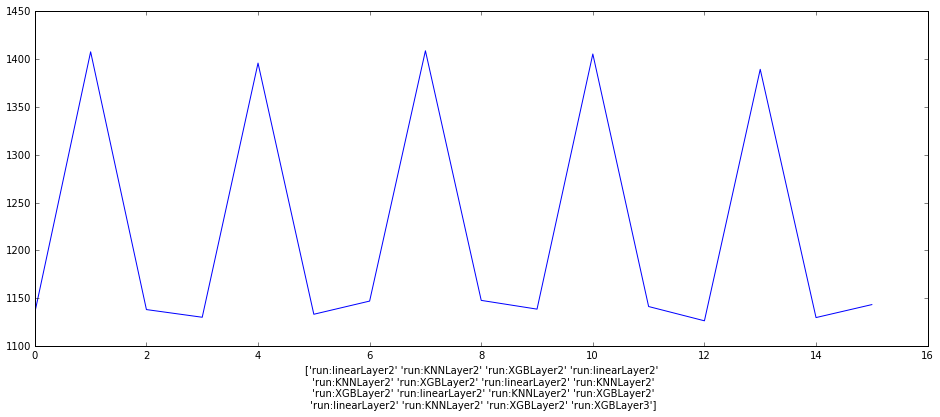

In [74]:

MAE_tracking_graph=np.array(MAE_tracking)

print(MAE_tracking_graph.T)
plt.figure(figsize=(16,6))
plt.plot(MAE_tracking_graph.T[1])
plt.xlabel(MAE_tracking_graph.T[0])

plt.show()

del MAE_tracking_graph

### Predict layer 1 on test 

In [75]:
#load the results from JustStacking-Layer1.ipynb


if dataset=='validation_train':
    x_layer2_test=joblib.load(cachedir+'x_layer2_test_validation.npy' ) 
else:
    x_layer2_test=joblib.load(cachedir+'x_layer2_test_final.npy' ) 


### Layer 2 predictions!

In [76]:
#Linear
start_time = time.time()
layer3_predict_linear=layer2_Lin_regr.predict(x_layer2_test)
print("Linear predict time:{}s".format(round((time.time()-start_time), 3) ))    
x_layer3_test = layer3_predict_linear

#KNeighborsRegressor
start_time = time.time()
layer3_predict_KNeighbors=layer2_KNN_regr.predict(x_layer2_test)
print("KNeighbors predict time:{}s".format(round((time.time()-start_time), 3) ))    
x_layer3_test = np.column_stack((x_layer3_test,layer3_predict_KNeighbors))  


# The XGB version of layer 2
dtest = xgb.DMatrix(x_layer2_test)
start_time = time.time()
layer3_gbdt_predict=layer2_gbdt.predict(dtest)
print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))    
x_layer3_test = np.column_stack((x_layer3_test,layer3_gbdt_predict))  


# ? average those weighted to XGB
start_time = time.time()

layer3_avg_predict=(layer3_predict_linear+layer3_predict_KNeighbors+layer3_gbdt_predict+layer3_gbdt_predict)/4
print("AVG predict time:{}s".format(round((time.time()-start_time), 3) ))    

x_layer3_test = np.column_stack((x_layer3_test,layer3_avg_predict))  



Linear predict time:0.008s
KNeighbors predict time:3.383s
XGB predict time:0.796s
AVG predict time:0.001s


In [77]:
#spit out that good scoring linear result...
test_data['loss']=np.exp(layer3_predict_linear)-200


result=test_data[['id','loss',]]
output_fname="result_submission_stack_linear.csv"
display(writeData(result,output_fname))

['id,loss\n',
 '4,1605.37047333\n',
 '6,1885.77219536\n',
 '9,9821.21870853\n',
 '12,6717.69694934\n']

### Predict Layer 3

In [78]:
#the XGB version:
dtest = xgb.DMatrix(x_layer3_test)
test_data['loss']=np.exp(layer3_gbdt.predict(dtest))-200

result=test_data[['id','loss',]]
output_fname="result_submission_stack_xgb.csv"
display(writeData(result,output_fname))



['id,loss\n',
 '4,1736.60412598\n',
 '6,1957.61914062\n',
 '9,8454.96484375\n',
 '12,6554.63085938\n']

In [79]:
#let's have a look at the std of the result, as a cross check
print("result std:",result.std(axis=0))

('result std:', id      170098.328125
loss      1841.557251
dtype: float32)


In [80]:
# if we are doing the validation set run, let load up it's reality:
original_loss=test_data['loss']
MAE=np.mean(abs( result['loss']-  np.exp(original_loss)-200))
print("final loss:{}\n".format(MAE))
print(result['loss'],np.exp(original_loss)-200)


loading: ./input/test_data_validation_train_all_features.csv
Dataset has 37664 samples with 135 features each.
final loss:2277.53117184

(0         1736.604126
1         1957.619141
2         8454.964844
3         6554.630859
4          877.071289
5         2187.149902
6         2416.182617
7          931.578857
8         2545.114990
9         2955.812012
10        2705.668213
11         983.927368
12        1264.186157
13        2019.687012
14        2647.411133
15        5545.541504
16        2036.293213
17        2577.570068
18        3094.073486
19        2479.062744
20        1889.698242
21        1271.037354
22        1270.528931
23        1104.724976
24        1741.738770
25        1130.369507
26        3697.153076
27        3863.527832
28         779.337280
29        2738.844238
             ...     
125516    1399.153442
125517    3726.340576
125518    2100.071533
125519    1744.312622
125520    1073.332886
125521     792.580505
125522    2386.332031
125523    2005.821777
1255

# EOF 